# Data Assimilation - Santarem_new

This notebook uses pre-fitted parameters to compare model predictions with observed data.

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import readHistData as hist
from scipy.stats import pearsonr

plt.rcParams.update({'font.size': 14, 'lines.linewidth': 2})

## 1. Load Data and Parameters

In [2]:
data = pd.read_csv('dataNew.csv')
print(f'Loaded {len(data)} time points')
data.head()

Loaded 24 time points


,Day,OVT_house,OVT_park,OVT_street,ADT_house,ADT_park,ADT_street,Temperature,Pluviosity
0,0,98.390635,0.0,0.000000,12.886482,0.000000,0.0,26.208571,62.950
1,30,70.934739,0.0,0.000000,0.000000,70.471834,0.0,26.065476,109.000
2,60,69.718941,0.0,0.000000,5.427754,0.000000,0.0,25.746607,112.300
3,90,13.158772,0.0,241.373780,1.308943,17.222903,0.0,25.721429,54.350
4,120,0.000000,0.0,392.018311,0.000000,59.789195,0.0,25.860714,26.025


In [3]:
with open('results_new_params.json', 'r') as f:
    fitted_params = json.load(f)
print('Fitted parameters loaded.')

Fitted parameters loaded.


In [4]:
days = data['Day'].values
obs_park_ovt = data['OVT_park'].values
obs_park_adt = data['ADT_park'].values
obs_house_ovt = data['OVT_house'].values
obs_house_adt = data['ADT_house'].values
obs_street_ovt = data['OVT_street'].values
obs_street_adt = data['ADT_street'].values
print(f'Days: {days[0]} to {days[-1]}')

Days: 0 to 690


## 2. Define Model Function

In [5]:
def compute_equilibria(params, days):
    Tminmu1, Tmaxmu1 = params["Tminmu1"], params["Tmaxmu1"]
    Tmin2, Tmax2 = params["Tmin2"], params["Tmax2"]
    Tmin3, Tmax3 = params["Tmin3"], params["Tmax3"]
    Tmingamma, Tmaxgamma = params["Tmingamma"], params["Tmaxgamma"]
    Tminr, Tmaxr = params["Tminr"], params["Tmaxr"]
    Tmink, Tmaxk = params["Tmink"], params["Tmaxk"]
    Tminee, Tmaxe = params["Tminee"], params["Tmaxe"]
    
    mu10, mu20, mu30 = 0.1170, 0.025, 0.01
    gamma0, r0, k0, e0 = 0.5596, 34, 89000, 0.24
    
    ovt_values, adt_values = [], []
    
    for t in days:
        T, P = hist.temperature(t), hist.pluviosity(t)
        
        Mmu1, Dmu1 = (Tminmu1 + Tmaxmu1) / 2, abs(Tmaxmu1 - Tminmu1) / 2
        Mmu2, Dmu2 = (Tmin2 + Tmax2) / 2, abs(Tmax2 - Tmin2) / 2
        Mmu3, Dmu3 = (Tmin3 + Tmax3) / 2, abs(Tmax3 - Tmin3) / 2
        Mgamma, Dgamma = (Tmingamma + Tmaxgamma) / 2, abs(Tmaxgamma - Tmingamma) / 2
        Mr, Dr = (Tminr + Tmaxr) / 2, abs(Tmaxr - Tminr) / 2
        Mk, Dk = (Tmink + Tmaxk) / 2, abs(Tmaxk - Tmink) / 2
        Me, De = (Tminee + Tmaxe) / 2, abs(Tmaxe - Tminee) / 2
        
        mu1 = (2 - hist.plateau(Dmu1, Mmu1, T)) * mu10
        mu2 = (2 - hist.plateau(Dmu2, Mmu2, T)) * mu20
        mu3 = (2 - hist.plateau(Dmu3, Mmu3, T)) * mu30
        gamma = hist.normal(Dgamma, Mgamma, T) * gamma0
        r = hist.phi(P) * hist.normal(Dr, Mr, T) * r0
        k = hist.phi(P) * hist.normal(Dk, Mk, T) * k0
        e = e0 * hist.normal(De, Me, T) * hist.phi(P)
        
        denom = mu1 * (mu2 + gamma) * (mu3 + e)
        Q0 = (gamma * e * r) / denom if denom != 0 else 0
        
        if Q0 > 1:
            eqADT = k * (gamma / mu1) * (1 - 1 / Q0)
            denom2 = mu1 * (mu3 + e)
            eqOVT = k * (gamma * r) / denom2 * (1 - 1 / Q0) if denom2 != 0 else 0
        else:
            eqADT, eqOVT = 0, 0
        
        ovt_values.append(eqOVT)
        adt_values.append(eqADT)
    
    return np.array(ovt_values), np.array(adt_values)

## 3. Compute Predictions

In [6]:
pred_park_ovt, pred_park_adt = compute_equilibria(fitted_params['park'], days)
pred_house_ovt, pred_house_adt = compute_equilibria(fitted_params['house'], days)
pred_street_ovt, pred_street_adt = compute_equilibria(fitted_params['street'], days)
print('Predictions computed.')

Predictions computed.


## 4. Compare Predictions with Observed Data by Terrain Type

In [7]:
def safe_pearsonr(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return pearsonr(x, y)[0]

corr_park_ovt = safe_pearsonr(obs_park_ovt, pred_park_ovt)
corr_park_adt = safe_pearsonr(obs_park_adt, pred_park_adt)
corr_house_ovt = safe_pearsonr(obs_house_ovt, pred_house_ovt)
corr_house_adt = safe_pearsonr(obs_house_adt, pred_house_adt)
corr_street_ovt = safe_pearsonr(obs_street_ovt, pred_street_ovt)
corr_street_adt = safe_pearsonr(obs_street_adt, pred_street_adt)

print('Correlations by Terrain Type:')
print(f'  Park OVT: {corr_park_ovt:.3f}, ADT: {corr_park_adt:.3f}')
print(f'  House OVT: {corr_house_ovt:.3f}, ADT: {corr_house_adt:.3f}')
print(f'  Street OVT: {corr_street_ovt:.3f}, ADT: {corr_street_adt:.3f}')

Correlations by Terrain Type:
  Park OVT: -0.132, ADT: 0.058
  House OVT: 0.543, ADT: 0.238
  Street OVT: 0.291, ADT: 0.157


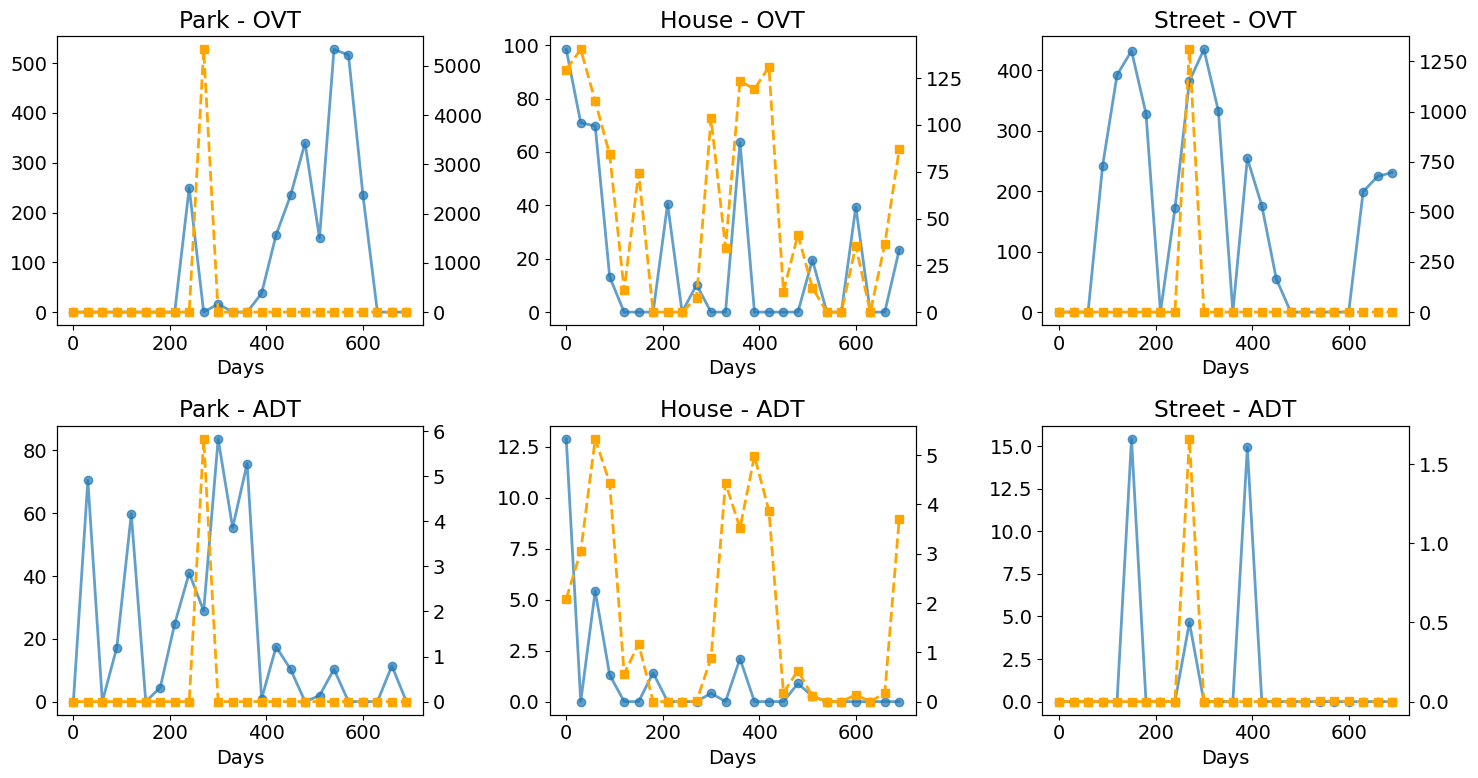

In [8]:
# Plot terrain comparisons
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

terrains = ['Park', 'House', 'Street']
obs_ovt = [obs_park_ovt, obs_house_ovt, obs_street_ovt]
pred_ovt = [pred_park_ovt, pred_house_ovt, pred_street_ovt]
obs_adt = [obs_park_adt, obs_house_adt, obs_street_adt]
pred_adt = [pred_park_adt, pred_house_adt, pred_street_adt]

for i, terrain in enumerate(terrains):
    ax = axes[0, i]
    ax.plot(days, obs_ovt[i], 'o-', label='Observed', alpha=0.7)
    ax2 = ax.twinx()
    ax2.plot(days, pred_ovt[i], 's--', color='orange', label='Predicted')
    ax.set_title(f'{terrain} - OVT')
    ax.set_xlabel('Days')
    
    ax = axes[1, i]
    ax.plot(days, obs_adt[i], 'o-', label='Observed', alpha=0.7)
    ax2 = ax.twinx()
    ax2.plot(days, pred_adt[i], 's--', color='orange', label='Predicted')
    ax.set_title(f'{terrain} - ADT')
    ax.set_xlabel('Days')

plt.tight_layout()
plt.show()

## 5. Neighborhood-Level Reconstruction

Combine terrain predictions using the proportion matrix to compare with observed neighborhood data.

In [9]:
# Load observed neighborhood data from original CSV
df_orig = pd.read_csv('../data/Santarem.csv')

# Handle missing values
JdSantaremOVT = df_orig['OVT_Jd_Santarem'].ffill().bfill()
RepublicaOVT = df_orig['OVT_Republica'].ffill().bfill()
SantarenzinhoOVT = df_orig['OVT_Santarenzinho'].ffill().bfill()

# Handle completely empty columns by using average of others
if JdSantaremOVT.isnull().all():
    JdSantaremOVT = (RepublicaOVT + SantarenzinhoOVT) / 2
if RepublicaOVT.isnull().all():
    RepublicaOVT = (JdSantaremOVT + SantarenzinhoOVT) / 2
if SantarenzinhoOVT.isnull().all():
    SantarenzinhoOVT = (JdSantaremOVT + RepublicaOVT) / 2

JdSantaremOVT = JdSantaremOVT.values
RepublicaOVT = RepublicaOVT.values
SantarenzinhoOVT = SantarenzinhoOVT.values

JdSantaremADT = df_orig['ADT_Jd_Santarem'].ffill().bfill().values
RepublicaADT = df_orig['ADT_Republica'].ffill().bfill().values
SantarenzinhoADT = df_orig['ADT_Santarenzinho'].ffill().bfill().values

print(f"Loaded observed data for {len(JdSantaremOVT)} time points.")

Loaded observed data for 24 time points.


In [10]:
# Load proportions from terrain analysis
# These should match what was computed in dataPreparation.ipynb
from PIL import Image

def isGreen(rgb):
    r, g, b = rgb
    if g > r and g > b and g > 50: return True
    if g > 40 and g > r * 0.9 and g > b * 1.1: return True
    return False

def isStreet(rgb_map):
    r, g, b = rgb_map
    if b > r and 200 < b < 245 and 200 < g < 235:
        if abs(r - g) < 30: return True
    return False

def count_terrain(roadmap_path, satellite_path):
    roadmap = Image.open(roadmap_path).convert('RGB')
    satellite = Image.open(satellite_path).convert('RGB')
    width, height = roadmap.size
    water, parks, streets, houses = 0, 0, 0, 0
    for x in range(0, width, 3):
        for y in range(0, height, 3):
            pm, ps = roadmap.getpixel((x, y))[:3], satellite.getpixel((x, y))[:3]
            if isStreet(pm): streets += 1
            elif isGreen(ps): parks += 1
            else: houses += 1
    return [0, parks, streets, houses]

neighborhoods = ['Jd_Santarem', 'Republica', 'Santarenzinho']
map_base_path = '../maps/Santarem_PA'

proportions_raw = []
for n in neighborhoods:
    counts = count_terrain(f'{map_base_path}/{n}/roadmap.png', f'{map_base_path}/{n}/satellite.png')
    proportions_raw.append(counts)
    print(f'  {n}: {counts}')

proportions = [np.array(c) / sum(c) for c in proportions_raw]
matProporcoes = np.array(proportions)

print("\nProportions matrix [water, parks, streets, houses]:")
print(matProporcoes)

  Jd_Santarem: [0, 8965, 29556, 143808]
  Republica: [0, 16593, 28935, 136801]
  Santarenzinho: [0, 13409, 26506, 142414]

Proportions matrix [water, parks, streets, houses]:
[[0.         0.04916936 0.16210257 0.78872807]
 [0.         0.09100582 0.15869664 0.75029754]
 [0.         0.07354288 0.14537457 0.78108255]]


In [11]:
# Combine terrain predictions using proportion matrix
n_times = len(days)

pred_jdsantarem_ovt = np.zeros(n_times)
pred_republica_ovt = np.zeros(n_times)
pred_santarenzinho_ovt = np.zeros(n_times)

pred_jdsantarem_adt = np.zeros(n_times)
pred_republica_adt = np.zeros(n_times)
pred_santarenzinho_adt = np.zeros(n_times)

for t in range(n_times):
    # OVT predictions [water, park, street, house]
    terrain_ovt = [0, pred_park_ovt[t], pred_street_ovt[t], pred_house_ovt[t]]
    combined_ovt = matProporcoes @ terrain_ovt
    pred_jdsantarem_ovt[t] = combined_ovt[0]
    pred_republica_ovt[t] = combined_ovt[1]
    pred_santarenzinho_ovt[t] = combined_ovt[2]
    
    # ADT predictions
    terrain_adt = [0, pred_park_adt[t], pred_street_adt[t], pred_house_adt[t]]
    combined_adt = matProporcoes @ terrain_adt
    pred_jdsantarem_adt[t] = combined_adt[0]
    pred_republica_adt[t] = combined_adt[1]
    pred_santarenzinho_adt[t] = combined_adt[2]

print("Combined predictions computed for all neighborhoods.")

Combined predictions computed for all neighborhoods.


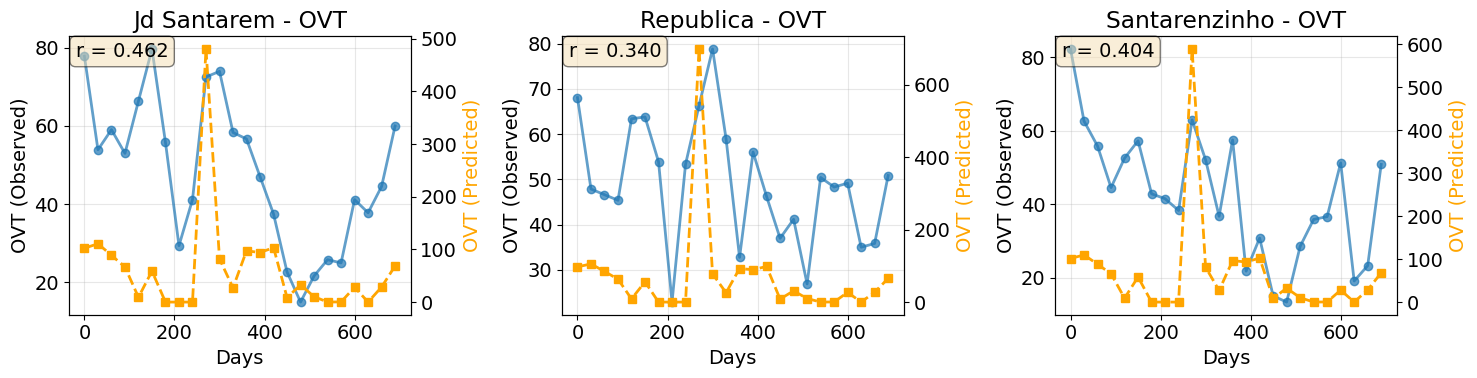

In [12]:
# Plot neighborhood-level OVT comparisons
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

neigh_names = ['Jd Santarem', 'Republica', 'Santarenzinho']
obs_ovt_list = [JdSantaremOVT, RepublicaOVT, SantarenzinhoOVT]
pred_ovt_list = [pred_jdsantarem_ovt, pred_republica_ovt, pred_santarenzinho_ovt]

corr_neigh_ovt = []
for ax1, name, obs, pred in zip(axes, neigh_names, obs_ovt_list, pred_ovt_list):
    ax1.plot(days, obs, 'o-', label='Observed', alpha=0.7)
    ax1.set_xlabel('Days')
    ax1.set_ylabel('OVT (Observed)')
    ax1.grid(True, alpha=0.3)
    
    ax2 = ax1.twinx()
    ax2.plot(days, pred, 's--', color='orange', label='Predicted')
    ax2.set_ylabel('OVT (Predicted)', color='orange')
    
    ax1.set_title(f'{name} - OVT')
    corr = safe_pearsonr(obs, pred)
    corr_neigh_ovt.append(corr)
    ax1.text(0.02, 0.98, f'r = {corr:.3f}', transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

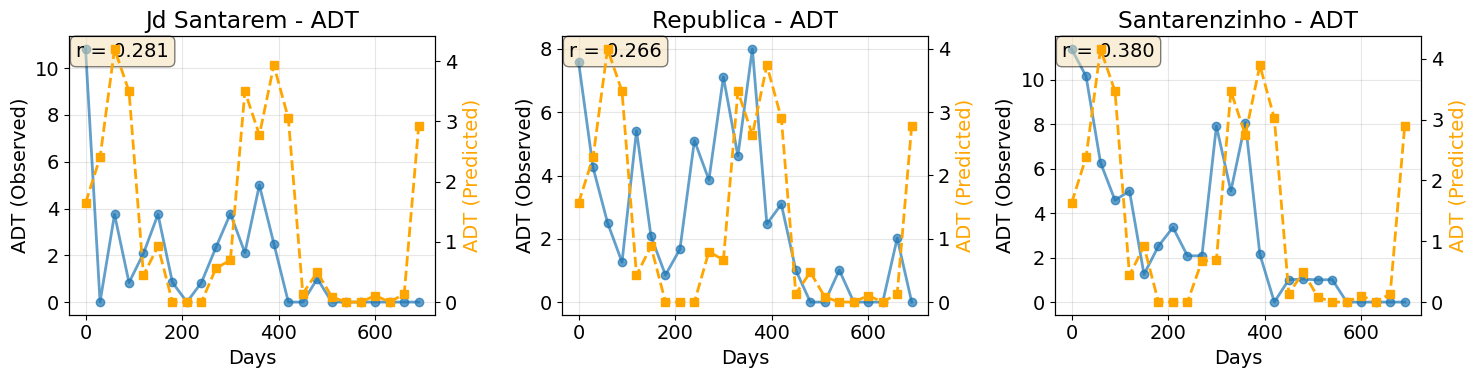

In [13]:
# Plot neighborhood-level ADT comparisons
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

obs_adt_list = [JdSantaremADT, RepublicaADT, SantarenzinhoADT]
pred_adt_list = [pred_jdsantarem_adt, pred_republica_adt, pred_santarenzinho_adt]

corr_neigh_adt = []
for ax1, name, obs, pred in zip(axes, neigh_names, obs_adt_list, pred_adt_list):
    ax1.plot(days, obs, 'o-', label='Observed', alpha=0.7)
    ax1.set_xlabel('Days')
    ax1.set_ylabel('ADT (Observed)')
    ax1.grid(True, alpha=0.3)
    
    ax2 = ax1.twinx()
    ax2.plot(days, pred, 's--', color='orange', label='Predicted')
    ax2.set_ylabel('ADT (Predicted)', color='orange')
    
    ax1.set_title(f'{name} - ADT')
    corr = safe_pearsonr(obs, pred)
    corr_neigh_adt.append(corr)
    ax1.text(0.02, 0.98, f'r = {corr:.3f}', transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## 6. Summary Statistics

In [14]:
print("=" * 60)
print("SUMMARY: Pearson Correlations")
print("=" * 60)

print("\n--- By Terrain Type ---")
print(f"{'Terrain':<10} {'OVT':>10} {'ADT':>10}")
print("-" * 30)
print(f"{'Park':<10} {corr_park_ovt:>10.3f} {corr_park_adt:>10.3f}")
print(f"{'House':<10} {corr_house_ovt:>10.3f} {corr_house_adt:>10.3f}")
print(f"{'Street':<10} {corr_street_ovt:>10.3f} {corr_street_adt:>10.3f}")

print("\n--- By Neighborhood (Combined) ---")
print(f"{'Neighborhood':<15} {'OVT':>10} {'ADT':>10}")
print("-" * 35)
for name, c_ovt, c_adt in zip(neigh_names, corr_neigh_ovt, corr_neigh_adt):
    print(f"{name:<15} {c_ovt:>10.3f} {c_adt:>10.3f}")

print("\n--- Overall Averages ---")
avg_terrain_ovt = np.nanmean([corr_park_ovt, corr_house_ovt, corr_street_ovt])
avg_terrain_adt = np.nanmean([corr_park_adt, corr_house_adt, corr_street_adt])
avg_neigh_ovt = np.nanmean(corr_neigh_ovt)
avg_neigh_adt = np.nanmean(corr_neigh_adt)

print(f"Avg. Terrain:     OVT = {avg_terrain_ovt:.3f}, ADT = {avg_terrain_adt:.3f}")
print(f"Avg. Neighborhood: OVT = {avg_neigh_ovt:.3f}, ADT = {avg_neigh_adt:.3f}")

SUMMARY: Pearson Correlations

--- By Terrain Type ---
Terrain           OVT        ADT
------------------------------
Park           -0.132      0.058
House           0.543      0.238
Street          0.291      0.157

--- By Neighborhood (Combined) ---
Neighborhood           OVT        ADT
-----------------------------------
Jd Santarem          0.462      0.281
Republica            0.340      0.266
Santarenzinho        0.404      0.380

--- Overall Averages ---
Avg. Terrain:     OVT = 0.234, ADT = 0.151
Avg. Neighborhood: OVT = 0.402, ADT = 0.309


## 7. Environmental Context

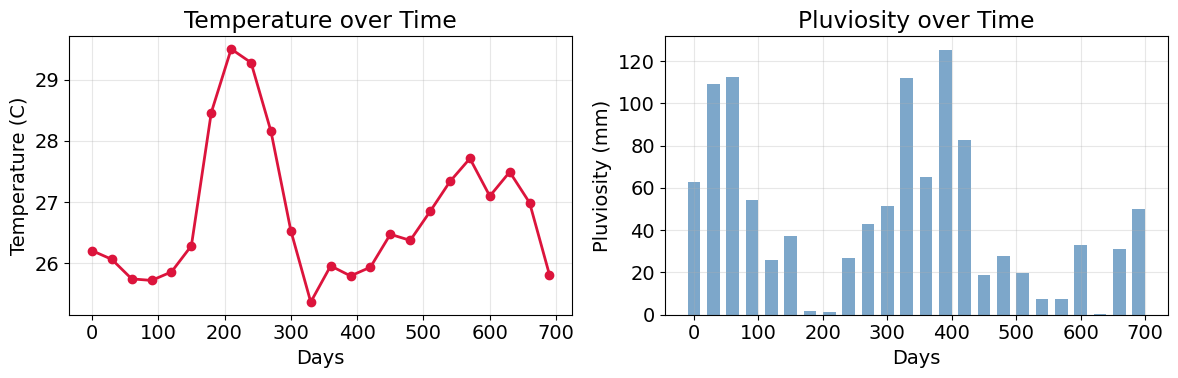

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

temps = [hist.temperature(t) for t in days]
pluvs = [hist.pluviosity(t) for t in days]

axes[0].plot(days, temps, 'o-', color='crimson')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Temperature (C)')
axes[0].set_title('Temperature over Time')
axes[0].grid(True, alpha=0.3)

axes[1].bar(days, pluvs, width=20, color='steelblue', alpha=0.7)
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Pluviosity (mm)')
axes[1].set_title('Pluviosity over Time')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()